In [101]:
import torch
import torchvision
import torchvision.transforms as transforms

In [102]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [103]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [104]:
import matplotlib.pyplot as plt
import numpy as np

In [105]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
data_iter = iter(trainloader)
images, labels = next(data_iter)


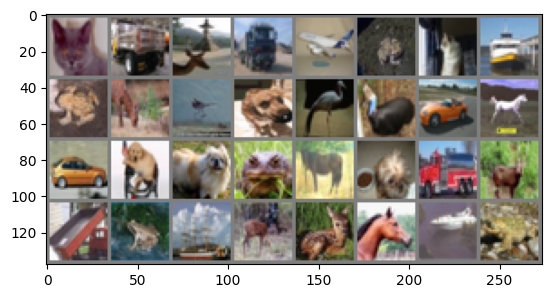

In [106]:
imshow(torchvision.utils.make_grid(images))

In [107]:
import torch.nn as nn
import torch.nn.functional as F


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_0 = ResNet()
model_0

ResNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [108]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9)
model_0.to(device)

ResNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [109]:
#create a train step.
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  #Put the model in train mode.
  model.train()

  #Setup train loss and train acc values
  train_loss, train_acc = 0,0

  #Loop through dataloader and data batches
  for batch, (X,y) in enumerate(dataloader):
    #Send data to the target device.
    X,y = X.to(device),y.to(device)

    #1.Forward pass.
    y_pred = model(X) #Ouputs model logits.

    #2.Calculate the loss.
    loss = loss_fn(y_pred,y)
    train_loss +=loss.item()

    #3.Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backwards
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    #Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc +=(y_pred_class==y).sum().item()/len(y_pred)

  #Adjust metrics to get average loss and accuracy per batch.
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [110]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device):
  #put the model in eval mode.
  model.eval()

  #setup the test_loss and test_acc values
  test_loss,test_acc = 0,0

  #Turn on inference mode
  with torch.inference_mode():

    #Loop through the data loader data batches.
    for batch, (X,y) in enumerate(dataloader):
      #Send data to target device.
      X,y = X.to(device),y.to(device)

      #1.Forward pass
      test_pred = model(X)

      #2.Calculate the test loss
      loss = loss_fn(test_pred,y)
      test_loss += loss.item()

      #3.Calculate the accuracy
      test_pred_class  = test_pred.argmax(dim=1)
      test_acc += (test_pred_class==y).sum().item()/ len(test_pred)



    #Adjust metrics to get average loss and accuracy per batch.
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [111]:
from tqdm.auto import tqdm
def train (model:torch.nn.Module,
           train_dataloader:torch.utils.data.DataLoader,
           test_dataloader:torch.utils.data.DataLoader,
           optimizer:torch.optim.Optimizer,
           loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
           epochs:int = 5):
  #2.Create empty results dictionary
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  #Loop through the training and testing steps for a number of epochs.
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
                                          model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer
                                      )

    test_loss,test_acc = test_step(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn)


    # print out what's happenin'
    print(

        f"Epoch: {epoch+1} |"
        f"Train Loss: {train_loss:.4f} |"
        f"Test Acc: {test_acc:.4f} |"
        f"Test Loss: {test_loss:.4f} |"
        f"Test Acc: {test_acc:.4f} |")

    #Update the dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [112]:
NUM_EPOCHS=10
#start the timer
from timeit import default_timer as timer
start_timer = timer()

#Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=trainloader,
                        test_dataloader=testloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

#End of the timer and print out how long it takes
end_timer = timer()

print(f"Total training time: {end_timer - start_timer:.2f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |Train Loss: 1.7544 |Test Acc: 0.4677 |Test Loss: 1.4608 |Test Acc: 0.4677 |
Epoch: 2 |Train Loss: 1.3583 |Test Acc: 0.5342 |Test Loss: 1.3047 |Test Acc: 0.5342 |
Epoch: 3 |Train Loss: 1.2148 |Test Acc: 0.5864 |Test Loss: 1.1773 |Test Acc: 0.5864 |
Epoch: 4 |Train Loss: 1.1372 |Test Acc: 0.5762 |Test Loss: 1.2143 |Test Acc: 0.5762 |
Epoch: 5 |Train Loss: 1.0663 |Test Acc: 0.5966 |Test Loss: 1.1485 |Test Acc: 0.5966 |
Epoch: 6 |Train Loss: 1.0172 |Test Acc: 0.5928 |Test Loss: 1.1655 |Test Acc: 0.5928 |
Epoch: 7 |Train Loss: 0.9666 |Test Acc: 0.6089 |Test Loss: 1.1468 |Test Acc: 0.6089 |
Epoch: 8 |Train Loss: 0.9325 |Test Acc: 0.6230 |Test Loss: 1.1048 |Test Acc: 0.6230 |
Epoch: 9 |Train Loss: 0.9026 |Test Acc: 0.6122 |Test Loss: 1.1322 |Test Acc: 0.6122 |
Epoch: 10 |Train Loss: 0.8798 |Test Acc: 0.6078 |Test Loss: 1.1712 |Test Acc: 0.6078 |
Total training time: 197.78 seconds
